This notebook is an amalagamation of multiple PyTorch tutorials including

- [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

# Imports and Paths

In [63]:
import torch
from torch import nn
import numpy as np

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Basics

Torch works very similar to numpy, as it is meant to be a replacement for NumPy using the power of GPU's.

In [2]:
torch.zeros([5,3])

tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]])

In [3]:
np.zeros([5,3])

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

## Converting between Torch and NumPy

When converting between Torch and NumPy, the Torch Tensor and NumPy array will share their underlying memory locations, and changing one will change the other.

In [5]:
a = torch.ones(5)
a

tensor([ 1.,  1.,  1.,  1.,  1.])

In [7]:
b = a.numpy()
b

array([ 1.,  1.,  1.,  1.,  1.], dtype=float32)

In [8]:
a.add_(1)
print(a)
print(b)

tensor([ 2.,  2.,  2.,  2.,  2.])
[ 2.  2.  2.  2.  2.]


Tensors can be moved onto any device using the `.to` method.

In [10]:
# let us run this cell only if CUDA is available
# We will use ``torch.device`` objects to move tensors in and out of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!

# Autograd: automatic differentiation

Central to all neural networks in PyTorch is the `autograd` package.  The `autograd` package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

`torch.Tensor` is the central class of the package. If you set its attribute `.requires_grad` as True, it starts to track all operations on it. When you finish your computation you can call `.backward()` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into `.grad` attribute.

To stop a tensor from tracking history, you can call `.detach()` to detach it from the computation history, and to prevent future computation from being tracked.

If you want to compute the derivatives, you can call ``.backward()`` on a ``Tensor``.

In [49]:
x = torch.ones(2, 2, requires_grad=True)
y = (x + 2)**2 *3
grad = torch.ones(y.shape)
y.backward(grad)
# out = y.mean()
print(x)
print(y)
print(x.grad)
# print(out)

tensor([[ 1.,  1.],
        [ 1.,  1.]])
tensor([[ 27.,  27.],
        [ 27.,  27.]])
tensor([[ 18.,  18.],
        [ 18.,  18.]])


How do we get a matrix of 18?

when we create `y` as a function of `x` we are actually creating the equation

$$ y = 3 \left(x+2\right)^2$$

So when we call `x.grad` we are asking for the gradient with respect to `x`

$$\dfrac{\partial y}{\partial x} = \dfrac{\partial}{\partial x} 3 \left(x+2\right)^2 = 6\left(x + 2\right) $$

when calling `y.backward` we set the gradient equal to 1, so Torch evaluates the gradient of x with respect to 1

$$6\left(1 + 2\right)  = 18$$

The size of the gradient value in `.backward()` has to match the size of variable, in this case `y`.  If we wanted to evaluate the gradient with respect to x at different values, we just need to put those values into the gradient

In [55]:
x = torch.ones(2, 2, requires_grad=True)
y = (x + 2)**2 *3
grad = torch.randint(1,4,y.shape)
y.backward(grad)
# out = y.mean()
print(x)
print(y)
print(grad)
print(x.grad)

tensor([[ 1.,  1.],
        [ 1.,  1.]])
tensor([[ 27.,  27.],
        [ 27.,  27.]])
tensor([[ 2.,  1.],
        [ 3.,  1.]])
tensor([[ 36.,  18.],
        [ 54.,  18.]])


You can do `autograd` over multiple functions

In [56]:
x = torch.ones(2, 2, requires_grad=True)
y = (x + 2)**2 *3
z = y.mean()
z.backward()
print(x)
print(y)
print(z)
print(x.grad)

tensor([[ 1.,  1.],
        [ 1.,  1.]])
tensor([[ 27.,  27.],
        [ 27.,  27.]])
tensor(27.)
tensor([[ 4.5000,  4.5000],
        [ 4.5000,  4.5000]])


In this case since `z` is a scalar if you leave the grad of `.backward()` empty it will default to 1.  You cannot leave the value empty for anything larger than a rank 0 tensor. 

$$ z = \dfrac{1}{4} \sum\limits_{i=1}^4 y_i = \dfrac{1}{4} \sum\limits_{i=1}^4 3 \left(x_i+2\right)^2$$

taking the gradient and using a grad equal to 1, each entry of the matrix is defined as 

$$\dfrac{\partial z}{\partial x} = \dfrac{\partial}{\partial x} \dfrac{1}{4}  3 \left(x_i+2\right)^2 = \dfrac{3}{2}  \left(x_i+2\right)  = \dfrac{3}{2} \left(1+2\right) = 4.5 $$

# Neural networks

# Training a classifier

## Loading and normalizing CIFAR10

In [62]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='/data/msnow/cifar/', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='/data/msnow/cifar/', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Look at some of the images

In [79]:
len(testset.test_labels)

10000

plane horse  frog   cat


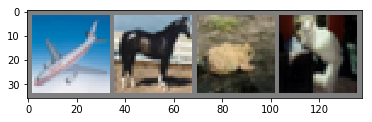

In [64]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define a CNN

In [65]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function and optimizer

In [66]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [82]:
for i, data in enumerate(trainloader, 0):
    break
inputs, labels = data

In [83]:
inputs.shape

torch.Size([4, 3, 32, 32])

In [67]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.195
[1,  4000] loss: 1.849
[1,  6000] loss: 1.670
[1,  8000] loss: 1.568
[1, 10000] loss: 1.490
[1, 12000] loss: 1.465
[2,  2000] loss: 1.413
[2,  4000] loss: 1.326
[2,  6000] loss: 1.337
[2,  8000] loss: 1.316
[2, 10000] loss: 1.282
[2, 12000] loss: 1.290
Finished Training


## Test the network on the test data

GroundTruth:    cat  ship  ship plane


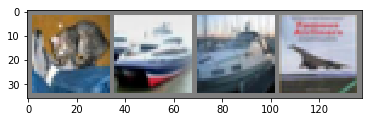

In [68]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [69]:
outputs = net(images)

In [70]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  truck   car   car  ship


In [71]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [72]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 83 %
Accuracy of  bird : 17 %
Accuracy of   cat : 37 %
Accuracy of  deer : 50 %
Accuracy of   dog : 44 %
Accuracy of  frog : 49 %
Accuracy of horse : 65 %
Accuracy of  ship : 49 %
Accuracy of truck : 57 %
